### **Importações iniciais**

In [2]:
import os

# Importações de visualização
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Importação do Dataset - Google Drive
from google.colab import files

In [3]:
# Importações de pré-processamento
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

# Normalização de dados
from sklearn.preprocessing import RobustScaler

# Redução de dimensionalidade / testa a independência entre variáveis
from sklearn.feature_selection import chi2

In [4]:
# Importações extra
import itertools

In [5]:
# Dataset de treino
df_train = pd.read_csv('fetal_health_train_multi.csv')
# Dataset de teste
df_test = pd.read_csv('fetal_health_test_multi.csv')

###**Separação entre treino e teste**



In [6]:
X_train = df_train.drop('fetal_health', axis=1)
y_train = df_train['fetal_health']

X_test = df_test.drop('fetal_health', axis=1)
y_test = df_test['fetal_health']

In [7]:
# Como visto, há muitos outliers
# Para isso será usado o RobustScaler, que lida melhor com outliers preciosos
# Melhor análise de fetos de sinais suspeitos ou patologicos (classes minoritarias)

scaler = RobustScaler()

# Ajuste da parte de treino e de teste
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Modelagem do SVM

In [8]:
import sys
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, recall_score, fbeta_score

def executar_svm_grid_search(estimator, param_grid, X_train, y_train, X_test, y_test, cv=5):
    """
    Executa GridSearchCV e imprime Acurácia e Recall específico da classe patológica.
    """

    # Instancia o GridSearchCV
    grid_search = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring='accuracy',
        n_jobs=-1,
        cv=cv,
        verbose=1,
        return_train_score=True
    )

    print(f"Iniciando ajuste do modelo (Grid Search com {cv} folds)...")

    # Treinamento do modelo
    grid_search.fit(X_train, y_train)

    # Predições no conjunto de teste usando o melhor modelo encontrado
    y_pred = grid_search.predict(X_test)

    # Cálculo do Recall Macro
    # Importante: pos_label=2 foca em quão bem o modelo detectou os casos de risco
    rec_score = recall_score(y_test, y_pred, average='macro')

    # Cálculo do F2-Score
    f2_macro = fbeta_score(
    y_test,
    y_pred,
    beta=2,
    average='macro'
  )

    # Exibição dos Resultados
    print("\n" + "_"*40)
    print("** Resultados do Grid Search **")
    print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")
    print(f"Melhor acurácia no Treino (CV): {grid_search.best_score_:.4f}")

    # Print destaque do Recall
    print(f"Recall macro: {rec_score:.4f}")


    print(f"🎯 F2-score (macro): {f2_macro:.4f}")

    print("\nRelatório de Classificação (Dados de Teste):")
    print(classification_report(y_test, y_pred))

    return grid_search

#### Matriz de Confusão

In [9]:
from sklearn.metrics import confusion_matrix

def plotar_matriz_confusao(modelo, X_test, y_test):
    """
    Gera e plota a matriz de confusão para o modelo treinado.
    """
    # Gerar as previsões usando o melhor modelo do GridSearch
    y_pred = modelo.predict(X_test)

    # Calcular a matriz de confusão
    cm = confusion_matrix(y_test, y_pred)

    # Configuração do gráfico
    plt.figure(figsize=(7, 5))

    # Rótulos das classes (Baseado na sua binarização: 1=Normal, 2=Anormal)
    labels = ['Normal', 'Suspeito/Patológico']

    # Plotagem usando Heatmap
    sns.heatmap(
        cm,
        annot=True,       # Escreve os números nos quadrados
        fmt='d',          # Formato 'd' para inteiros (sem notação científica)
        cmap='Blues',     # Paleta de cores azul
        xticklabels=labels,
        yticklabels=labels
    )

    plt.ylabel('Rótulo Real (Verdadeiro)')
    plt.xlabel('Rótulo Previsto pelo Modelo')
    plt.title('Matriz de Confusão - SVM')
    plt.show()

#### Modelagem multiclasse


Iniciando ajuste do modelo (Grid Search com 10 folds)...
Fitting 10 folds for each of 36 candidates, totalling 360 fits

________________________________________
** Resultados do Grid Search **
Melhores parâmetros encontrados: {'C': 50, 'gamma': 0.1, 'kernel': 'rbf'}
Melhor acurácia no Treino (CV): 0.8931
Recall macro: 0.7907
🎯 F2-score (macro): 0.7968

Relatório de Classificação (Dados de Teste):
              precision    recall  f1-score   support

         1.0       0.93      0.97      0.95       494
         2.0       0.71      0.58      0.64        88
         3.0       0.84      0.83      0.83        52

    accuracy                           0.90       634
   macro avg       0.83      0.79      0.81       634
weighted avg       0.89      0.90      0.90       634

________________________________________


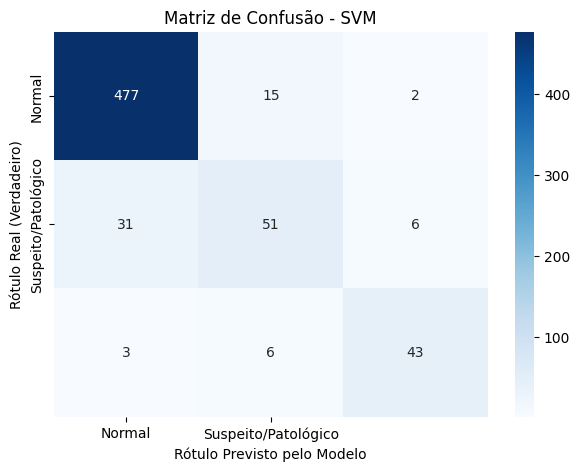

In [10]:
# Definição do Grid de Parâmetros

# Grid Otimizado (Removemos o 'poly' que é o vilão da demora)
svm_param_otimizado = {
    "C": [0.01, 0.1, 1, 10, 50, 100],
    "gamma": ["scale", 0.1, 0.01],
    "kernel": ["rbf", "linear"]
}


# Execução

# Chamada da função com os dados escalados (RobustScaler)
modelo_svm_grid = executar_svm_grid_search(
    estimator=SVC(),
    param_grid=svm_param_otimizado,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    cv=10
)

print('_'*40)

plotar_matriz_confusao(modelo_svm_grid, X_test_scaled, y_test)

#### Binarização do problema (normal x anormal)


In [11]:
X_train = df_train.drop('fetal_health', axis=1)
y_train = df_train['fetal_health']

y_train = y_train.replace(3, 2)

X_test = df_test.drop('fetal_health', axis=1)
y_test = df_test['fetal_health']

y_test = y_test.replace(3, 2)

# Refazendo o Scaler

scaler = RobustScaler()

# Ajuste da parte de treino e de teste
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### Modelagem binarizada

Iniciando ajuste do modelo (Grid Search com 10 folds)...
Fitting 10 folds for each of 36 candidates, totalling 360 fits

________________________________________
** Resultados do Grid Search **
Melhores parâmetros encontrados: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Melhor acurácia no Treino (CV): 0.9215
Recall macro: 0.8461
🎯 F2-score (macro): 0.8529

Relatório de Classificação (Dados de Teste):
              precision    recall  f1-score   support

         1.0       0.93      0.96      0.94       494
         2.0       0.85      0.73      0.78       140

    accuracy                           0.91       634
   macro avg       0.89      0.85      0.86       634
weighted avg       0.91      0.91      0.91       634

________________________________________


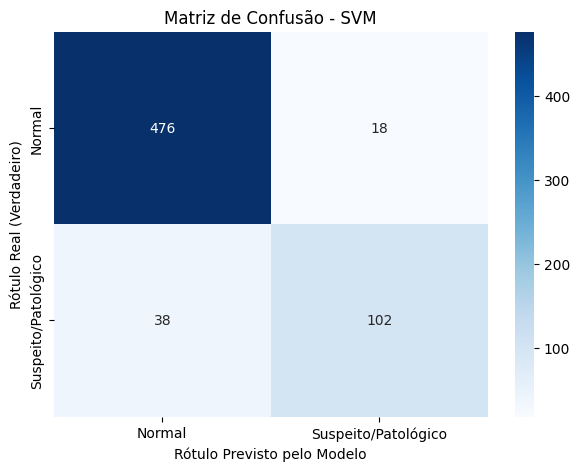

In [12]:
# Definição do Grid de Parâmetros

# Grid Otimizado (Removemos o 'poly' que é o vilão da demora)
svm_param_otimizado = {
    "C": [0.01, 0.1, 1, 10, 50, 100],
    "gamma": ["scale", 0.1, 0.01],
    "kernel": ["rbf", "linear"]
}


# Execução

# Chamada da função com os dados escalados (RobustScaler)
modelo_svm_grid = executar_svm_grid_search(
    estimator=SVC(),
    param_grid=svm_param_otimizado,
    X_train=X_train_scaled,
    y_train=y_train,
    X_test=X_test_scaled,
    y_test=y_test,
    cv=10
)

print('_'*40)

plotar_matriz_confusao(modelo_svm_grid, X_test_scaled, y_test)

#### Feature Importance

Calculando importância das variáveis (pode levar alguns segundos)...


/tmp/ipython-input-4036994246.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


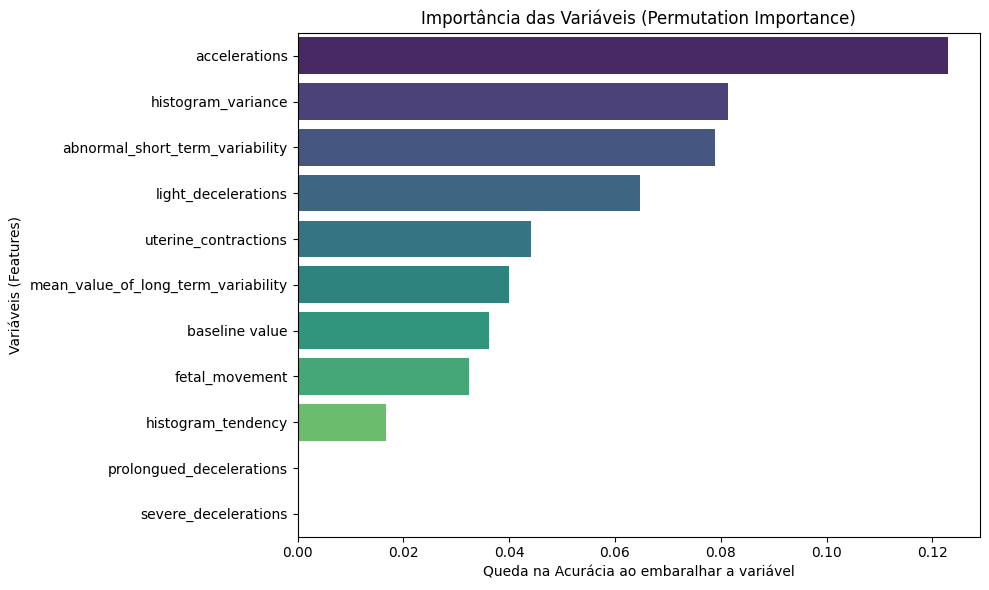

In [15]:
from sklearn.inspection import permutation_importance

def plotar_feature_importance(modelo, X_test, y_test, feature_names):
    """
    Calcula e plota a importância das features usando Permutation Importance.
    Funciona para qualquer kernel de SVM (Linear, RBF, Poly).
    """

    print("Calculando importância das variáveis (pode levar alguns segundos)...")

    # n_repeats=10: embaralha 10 vezes para ter uma média estatística sólida
    # random_state=42: para o resultado ser sempre o mesmo
    result = permutation_importance(
        modelo,
        X_test,
        y_test,
        n_repeats=10,
        random_state=42,
        n_jobs=-1
    )

    # Organizando os dados em um DataFrame para facilitar o plot
    # result.importances_mean é a queda média na acurácia do modelo
    df_importances = pd.DataFrame({
        'feature': feature_names,
        'importance': result.importances_mean
    })

    # Ordenando do maior para o menor
    df_importances = df_importances.sort_values(by='importance', ascending=False)

    # Plotagem
    plt.figure(figsize=(10, 6))

    sns.barplot(
        x='importance',
        y='feature',
        data=df_importances,
        palette='viridis'
    )

    plt.title('Importância das Variáveis (Permutation Importance)')
    plt.xlabel('Queda na Acurácia ao embaralhar a variável')
    plt.ylabel('Variáveis (Features)')
    plt.tight_layout()
    plt.show()

# --- Execução ---

# Recuperando os nomes das colunas originais (antes do scaler, a ordem se mantém)
# O objeto 'X' original tem os nomes das colunas
nomes_features = X_train.columns

plotar_feature_importance(
    modelo_svm_grid,
    X_test_scaled,
    y_test,
    nomes_features
)

#### Curva ROC

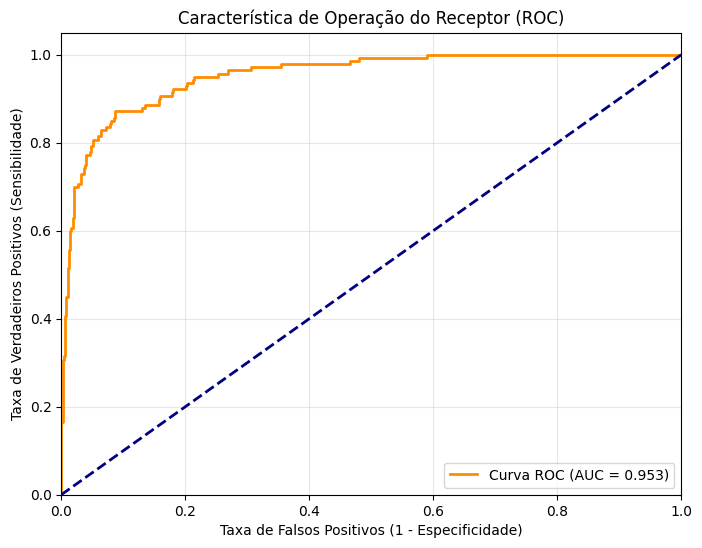

In [16]:
from sklearn.metrics import roc_curve, auc

def plotar_curva_roc(modelo, X_test, y_test):
    """
    Plota a curva ROC e calcula a AUC para um modelo SVM.
    Usa decision_function para obter os scores de classificação.
    """

    # 1. Obter os scores de decisão
    # O SVM usa 'decision_function' (distância do hiperplano)
    # Se o modelo fosse uma Random Forest, usaríamos predict_proba
    if hasattr(modelo, "decision_function"):
        y_score = modelo.decision_function(X_test)
    else:
        # Fallback caso você troque de modelo no futuro (ex: para Regressão Logística)
        y_score = modelo.predict_proba(X_test)[:, 1]

    # 2. Calcular taxas de Falsos Positivos (FPR) e Verdadeiros Positivos (TPR)
    # pos_label=2 define que a classe "Suspeito/Patológico" é a classe positiva
    fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=2)

    # 3. Calcular a Área Sob a Curva (AUC)
    roc_auc = auc(fpr, tpr)

    # 4. Configuração do Gráfico
    plt.figure(figsize=(8, 6))

    # Plot da curva do modelo
    plt.plot(
        fpr,
        tpr,
        color='darkorange',
        lw=2,
        label=f'Curva ROC (AUC = {roc_auc:.3f})'
    )

    # Plot da linha de referência (classificador aleatório)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Estilização
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (1 - Especificidade)')
    plt.ylabel('Taxa de Verdadeiros Positivos (Sensibilidade)')
    plt.title('Característica de Operação do Receptor (ROC)')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)

    plt.show()

# --- Execução ---

# Chamada da função com o modelo treinado (grid) e dados de teste escalados
plotar_curva_roc(modelo_svm_grid, X_test_scaled, y_test)